In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedStratifiedKFold
from sklearn.linear_model    import *
from sklearn.metrics         import *
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import *
from sklearn.tree      import *
from   sklearn.compose            import *
from   sklearn.ensemble           import *
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

## Load Data

### Data Sources
CA Solar Generation - US EIA: https://www.eia.gov/opendata/qb.php?category=3390106

Weather - NOAA: https://www.ncdc.noaa.gov/crn/qcdatasets.html

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/elysecs/ML_Lab_FinalProject/main/bodega_solar_join.csv')

In [3]:
X = df.iloc[:,2:]
y = df['MWh']

## Drop X, y records with null values

In [4]:
# Remove null rows outside pipeline since target also needs to be transformed
def filter_data(X, y):
    "Filter data - remove from both X and y."
    # Remove rows with null solar radiation feature
    X1 = X[X['SOLARAD']!=999]
    y1 = y[X['SOLARAD']!=999]
    
    # Remove rows with " -9"
    X2 = X1[~((X1.T_HR_AVG.str.contains(' -9')) | (X1.T_MIN.str.contains(' -9')))]
    y2 = y1[~((X1.T_HR_AVG.str.contains(' -9')) | (X1.T_MIN.str.contains(' -9')))]
    
    convert_dict = {'T_HR_AVG': float, 
            'T_MAX': float,
            'T_MIN': float,
            'P_CALC': float, 
            'SOIL_MOISTURE_10': float,
            'SOIL_MOISTURE_100': float, 
            'SOIL_TEMP_5': float,
           } 
  
    X3 = X2.astype(convert_dict) 
    
    return X3, y2

In [5]:
X_filtered, y_filtered = filter_data(X,y)

In [6]:
X_train_all, X_test, y_train_all, y_test= train_test_split(X_filtered, y_filtered, test_size=.15, random_state=10) 
X_train, X_validation, y_train, y_validation= train_test_split(X_train_all, y_train_all, test_size=.15, random_state=10)

## Feature Importance

In [7]:
algorithms = [ARDRegression(), BayesianRidge(), ElasticNet(), HuberRegressor(), 
 Lars(), Lasso(), LassoLars(), LassoLarsIC(), LinearRegression(),
 ElasticNet(), OrthogonalMatchingPursuit(), PassiveAggressiveRegressor(), 
 Ridge(), SGDRegressor(), TheilSenRegressor(),RandomForestRegressor(), 
 DecisionTreeRegressor(), ExtraTreeRegressor()]

In [8]:
# Initial model search
d={}
for algo in algorithms:
    pipe = Pipeline([('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(746.25, 'RandomForestRegressor'),
 (923.43, 'DecisionTreeRegressor'),
 (985.38, 'ExtraTreeRegressor'),
 (1440.9, 'HuberRegressor'),
 (1603.91, 'Lars')]

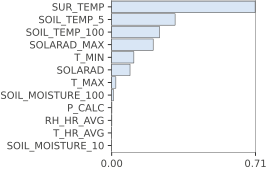

In [9]:
# Suspect collinearity, Look at feature importance
# This seems weird, solar should be most important -> codependent features
lm = LinearRegression()
lm.fit(X_train_all, y_train_all)

from rfpimp import * # See https://explained.ai/rf-importance/index.html
I = importances(lm, X_train_all, y_train_all)
plot_importances(I)

In [10]:
# Feature importance all variables
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train_all, y_train_all)
for col, imp in zip(X_train.columns,clf.feature_importances_):
    print(f'{col:<20} - {round(imp,3):^10}')

T_HR_AVG             -   0.005   
T_MAX                -   0.006   
T_MIN                -   0.008   
P_CALC               -   0.003   
SOLARAD              -    0.82   
SOLARAD_MAX          -   0.019   
SUR_TEMP             -   0.028   
RH_HR_AVG            -   0.041   
SOIL_MOISTURE_10     -   0.012   
SOIL_MOISTURE_100    -   0.008   
SOIL_TEMP_5          -   0.031   
SOIL_TEMP_100        -   0.019   


In [11]:
# Remove correlated variables
non_corr_vars = ['SOLARAD', 'SUR_TEMP', 'T_HR_AVG','RH_HR_AVG','SOIL_MOISTURE_10','P_CALC']

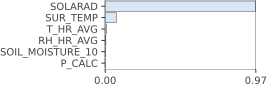

In [12]:
# Remove soil moisture and precipitation variables
lm = LinearRegression()
lm.fit(X_train_all[non_corr_vars], y_train_all)
I = importances(lm, X_train_all[non_corr_vars], y_train_all)
plot_importances(I)

In [13]:
# Feature importance without correlated variables
# Precipitation feature not very important
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train_all[non_corr_vars], y_train_all)
for col, imp in zip(X_train_all[non_corr_vars].columns,clf.feature_importances_):
    print(f'{col:<20} - {round(imp,3):^10}')

SOLARAD              -   0.838   
SUR_TEMP             -   0.044   
T_HR_AVG             -    0.03   
RH_HR_AVG            -   0.051   
SOIL_MOISTURE_10     -   0.034   
P_CALC               -   0.004   


In [14]:
# Check feature importance, solar radiation important
fs = SelectFromModel(RandomForestRegressor(), 
                     max_features=3)

fs.fit_transform(X_train, y_train)
fs.get_support()

array([False, False, False, False,  True, False, False, False, False,
       False, False, False])

## Feature Transformation

In [15]:
# Subset of algorithms
algorithms = [HuberRegressor(), PassiveAggressiveRegressor(), RandomForestRegressor(),
              DecisionTreeRegressor(), ExtraTreeRegressor()]

In [16]:
# Algs on subset of features
# MAE is worse which is surprising, correlated features are helping prediction
d={}
for algo in algorithms:
    pipe = Pipeline([('lm',     algo)])
    pipe.fit(X_train[non_corr_vars], y_train)
    y_pred = pipe.predict(X_validation[non_corr_vars])
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((v,k) for k,v in d.items()))[:5]

[(863.643845671602, 'RandomForestRegressor'),
 (1069.1381886087768, 'DecisionTreeRegressor'),
 (1133.844070961718, 'ExtraTreeRegressor'),
 (1512.3268755720896, 'HuberRegressor'),
 (3942.806104899919, 'PassiveAggressiveRegressor')]

In [17]:
# All features: Scale, doesnt help forest algs
d={}
for algo in algorithms:
    pipe = Pipeline([('scaler', StandardScaler()),
                    ('lm',     algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(739.77, 'RandomForestRegressor'),
 (945.03, 'DecisionTreeRegressor'),
 (970.76, 'ExtraTreeRegressor'),
 (1398.29, 'PassiveAggressiveRegressor'),
 (1420.28, 'HuberRegressor')]

In [18]:
# Scale everything but solar, doesnt change much
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',
               'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 
               'SOIL_MOISTURE_100','SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('scaler', StandardScaler())])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')
d={}
for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(742.38, 'RandomForestRegressor'),
 (950.15, 'DecisionTreeRegressor'),
 (992.99, 'ExtraTreeRegressor'),
 (1440.35, 'HuberRegressor'),
 (7721.02, 'PassiveAggressiveRegressor')]

In [19]:
# Scale solar, little impact
num_columns = ['SOLARAD', 'SOLARAD_MAX']
num_pipe = Pipeline([('scaler', StandardScaler())])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')
d={}
for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(745.14, 'RandomForestRegressor'),
 (923.32, 'DecisionTreeRegressor'),
 (985.61, 'ExtraTreeRegressor'),
 (1438.31, 'HuberRegressor'),
 (1528.09, 'PassiveAggressiveRegressor')]

In [20]:
# Quantile Transform all features, little impact
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',  'SOLARAD', 'SOLARAD_MAX',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']
num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')
d={}
for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(736.71, 'RandomForestRegressor'),
 (934.22, 'DecisionTreeRegressor'),
 (1029.24, 'ExtraTreeRegressor'),
 (1389.7, 'PassiveAggressiveRegressor'),
 (1398.01, 'HuberRegressor')]

In [21]:
# Quantile Transform non solar features, small decrease
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')
d={}
for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mae
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(753.45, 'RandomForestRegressor'),
 (932.37, 'DecisionTreeRegressor'),
 (958.14, 'ExtraTreeRegressor'),
 (1432.1, 'HuberRegressor'),
 (2260.6, 'PassiveAggressiveRegressor')]

In [22]:
# Try binning Solar, look for best parameters
bin_columns = ['SOLARAD']
bin_pipe = Pipeline([('kbins', KBinsDiscretizer())])

preprocessing = ColumnTransformer([('bin', bin_pipe, bin_columns),
                                   ], remainder='passthrough')
pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('clf', RandomForestRegressor())
    ])

search_space = [{'clf': [RandomForestRegressor()],  # Actual Estimator
                 'preprocessing__bin__kbins__encode': ['onehot', 'onehot-dense', 'ordinal'],
                'preprocessing__bin__kbins__strategy': ['uniform', 'quantile', 'kmeans'],
                'preprocessing__bin__kbins__n_bins': [5,7,10],}]

In [23]:
rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
cv = GridSearchCV(pipe, 
                search_space, 
                scoring='neg_mean_absolute_error',
                cv=rskf, 
                n_jobs=-1,
                verbose=1)
cv.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('bin',
                                                                         Pipeline(steps=[('kbins',
                                                                                          KBinsDiscretizer())]),
                                                                         ['SOLARAD'])])),
                                       ('clf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestRegressor()],
                          'preprocessing__bin__kbins__encode': ['onehot',
                                                                'onehot-dense',
                                                                'ordinal'],
      

In [24]:
print(f'Best MAE-score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')

Best MAE-score: -711.027

Best parameter set: {'clf': RandomForestRegressor(), 'preprocessing__bin__kbins__encode': 'onehot-dense', 'preprocessing__bin__kbins__n_bins': 10, 'preprocessing__bin__kbins__strategy': 'kmeans'}



In [25]:
# Binning Solar doesn't help
bin_pipe = Pipeline([('kbins', KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='kmeans'))])
pipe = Pipeline([('preprocessing', preprocessing), 
                 ('lm',     RandomForestRegressor())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_validation)
mae = mean_absolute_error(y_validation, y_pred)
print(f"{'RF':<17} - mean absolute error: {mae:,.2f}")

RF                - mean absolute error: 760.24


## Model Selection

In [26]:
# Cross validation to find best model
for algo in algorithms:
    from sklearn.model_selection import cross_val_score
    clf = algo
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    avg = -np.mean(scores)
    print(f"{algo.__class__.__name__:<25} - avg mae: {avg:,.2f}")

HuberRegressor            - avg mae: 1,456.11
PassiveAggressiveRegressor - avg mae: 2,033.54
RandomForestRegressor     - avg mae: 706.90
DecisionTreeRegressor     - avg mae: 898.51
ExtraTreeRegressor        - avg mae: 965.71


In [35]:
# MSE gives very high values, unreadable
d={}
for algo in algorithms:
    pipe = Pipeline([('lm',     algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    d[algo.__class__.__name__]=mse
sorted( ((round(v,2),k) for k,v in d.items()))[:5]

[(1459780.61, 'RandomForestRegressor'),
 (3161831.23, 'DecisionTreeRegressor'),
 (3363310.62, 'ExtraTreeRegressor'),
 (5145630.28, 'HuberRegressor'),
 (12397694.14, 'PassiveAggressiveRegressor')]

In [27]:
# Hyperparameter search - Random Forest
hyperparameters = dict(n_estimators=[75,100,125], 
                       max_features=['auto','sqrt','log2'],
                       criterion=['mse','mae']
                       )
clf_grid = GridSearchCV(RandomForestRegressor(), 
                                    hyperparameters, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [75, 100, 125]},
             verbose=1)

In [28]:
# Best parameters
print(f"The validation set accuracy - {clf_grid.score(X_validation, y_validation):.2%}")
print(f'Best score: {clf_grid.best_score_:.3f}')
print(f'Best parameter set: {clf_grid.best_params_}')

The validation set accuracy - 91.12%
Best score: 0.922
Best parameter set: {'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 125}


In [29]:
# Hyperparameter search - Extra Trees Forest
clf_grid = GridSearchCV(ExtraTreesRegressor(), 
                                    hyperparameters, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [75, 100, 125]},
             verbose=1)

In [30]:
print(f"The validation set accuracy - {clf_grid.score(X_validation, y_validation):.2%}")
print(f'Best score: {clf_grid.best_score_:.3f}')
print(f'Best parameter set: {clf_grid.best_params_}')

The validation set accuracy - 91.75%
Best score: 0.926
Best parameter set: {'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 125}


## Candidate Models

In [31]:
num_columns = ['T_HR_AVG', 'T_MAX', 'T_MIN', 'P_CALC',
       'SUR_TEMP', 'RH_HR_AVG', 'SOIL_MOISTURE_10', 'SOIL_MOISTURE_100',
       'SOIL_TEMP_5', 'SOIL_TEMP_100']

num_pipe = Pipeline([('quant', QuantileTransformer(output_distribution='normal'))])

preprocessing = ColumnTransformer([('continuous',num_pipe, num_columns),
                                   ], remainder='passthrough')

In [32]:
# Try RF
scores=[]
for _ in range(5):
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('rf',   RandomForestRegressor(criterion='mae',n_estimators=125))])
    X_train, X_validation, y_train, y_validation= train_test_split(X_train_all, y_train_all, test_size=.15)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    scores.append(mean_absolute_error(y_validation, y_pred))
avg=np.mean(scores)
print(f"{'RF':<10} - avg MAE: {avg:,.2f}")

RF         - avg MAE: 714.83


In [33]:
# Try ExtraTrees - Final Model
scores=[]
for _ in range(5):
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('rf',   ExtraTreesRegressor(criterion='mae',n_estimators=75))])
    X_train, X_validation, y_train, y_validation= train_test_split(X_train_all, y_train_all, test_size=.15)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    scores.append(mean_absolute_error(y_validation, y_pred))
avg=np.mean(scores)
print(f"{'Extra Trees':<10} - avg MAE: {avg:,.2f}")

Extra Trees - avg MAE: 678.68


# Final Model on Test Data

In [34]:
# Test Data - Extra Trees
pipe = Pipeline([('preprocessing', preprocessing), 
                     ('rf',   ExtraTreesRegressor(criterion='mae',n_estimators=75))])
pipe.fit(X_train_all, y_train_all)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"{'Extra Trees':<10} - mean absolute error: {mae:,.2f}")

Extra Trees - mean absolute error: 690.13
